In [75]:
import pandas as pd
from os import chdir
import subprocess
import glob
import matplotlib.pyplot as plt
from functools import reduce

# local import (Hirotaka's myfunctions.py script)
import myfunctions as myfunc

In [5]:
!mkdir temp2
chdir('temp2')

mkdir: cannot create directory 'temp2': File exists


In [6]:
# Get the id file, covariate file (all European)
wgsfolder = '/data/CARD/PD/GENOMES/august19/genotypes'
# wgsfolder = '/data/CARD/PD/WGS/june2019'
idfile = '_keep.id'
demog = pd.read_csv('/data/LNG/iwakih2/ampPD/data1_out/PP_PD_BF_HB_LC_demog.csv')
euro = pd.read_csv(f'/data/CARD/PD/GENOMES/august19/genotypes/PCA_filtered_europeans.txt', sep=' ',
                  header=None, names=['FID', 'IID'])
df = pd.merge(demog, euro, left_on='WGSID', right_on='IID')
df['FID'] = df.WGSID
df['IID'] = df.WGSID
df.RECRUIT=['CTR' if i=='HC' else i for i in df.RECRUIT]
df = df[df.RECRUIT.isin(['CTR', 'PD'])]
df = df[df.RECRUIT==df.LASTDIAG]
df['pheno'] = [1 if i=='PD' else 0 for i in df.RECRUIT]
df['AAD'] = df.AADi.where(df.pheno==0, other=df.AAOi)
df['AGE'] = df.AGEatBL.where(df.pheno==0, other=df.AAD)

df[['FID', 'IID', 'pheno']].to_csv(idfile, index=False, sep='\t', header=None)
df[['FID', 'IID', 'AGE', 'FEMALE']].to_csv('_qcovar.txt', index=False, sep='\t', header=None)

In [ ]:
# df.shape

In [ ]:
# used this to generate pca for chr1 just for testing purposes-- prune and merge all chrs first then run PCA
with open('_pca.swarm', 'w') as f:
    for chrnum in range(1,2):
        pfile = f'{wgsfolder}/pd.june2019.chr{chrnum}.sqc'
        out_pcs = f'chr{chrnum}.pca'
        plink_pca_cmd = f'\
plink2 --pfile {pfile}\
 --pca 280\
 --out {out_pcs}\n'
        
        f.write(plink_pca_cmd)
#         print(plink_pca_cmd)

In [ ]:
!swarm -f _pca.swarm -g 64 --time=10:00:00 -t 20 --logdir swarm --module plink/2.0_alpha_1_final --partition=norm

In [ ]:
with open('_script1.swarm', 'w') as f:
    for chrnum in range(1,23):
#         pfile = f'{wgsfolder}/pd.june2019.chr{chrnum}.sqc'
        pfile = f'{wgsfolder}/pd.june2019.chr{chrnum}.freeze9.sqc'
        freqfile = f'freq.{chrnum}'
        plinkcmd = f"\
plink2 --pfile {pfile}\
 --keep {idfile} \
 --freq \
 --out {freqfile}\n"
        f.write(plinkcmd)
#         myfunc.shell_do(plinkcmd)
    f.close()

In [ ]:
!swarm -f _script1.swarm -g 64 --time=10:00:00 -t 20 --logdir swarm --module plink/2.0_alpha_1_final --partition=norm

In [ ]:
from dask.distributed import Client, progress
# client should match the qued number of threads
client = Client(processes=False, threads_per_worker=2,
                n_workers=2, memory_limit='30GB')
import dask
import dask.dataframe as dd

# testing out just 2 maf bins
def MAFbin(x):
    if x>0:
        if x<0.01:
            return(1)
        else:
            return(2)
    else:
        return(0)




#try testing fewer maf bins
# def MAFbin(x):
#     if x>0:
#         if x<0.001:
#             return(1)
#         elif x<0.01:
#             return(2)
#         elif x<0.1:
#             return(3)
#         elif x<0.25:
#             return(4)
#         elif x<0.5:
#             return(5)
#         else:
#             return(6)
#     else:
#         return(0)



# def MAFbin(x):
#     if x>0:
#         if x<0.001:
#             return(1)
#         elif x<0.01:
#             return(2)
#         elif x<0.1:
#             return(3)
#         elif x<0.2:
#             return(4)
#         elif x<0.3:
#             return(5)
#         elif x<0.4:
#             return(6)
#         else:
#             return(7)
#     else:
#         return(0)



In [ ]:
client.close()

In [ ]:
# total_counts_df = pd.DataFrame(index=[0,1,2,3,4,5,6])
#test for 2 maf bins
total_counts_df = pd.DataFrame(index=[0,1,2])

for chrnum in range(1,23):
    freqfile = f'freq.{chrnum}'

    df = dd.read_csv(f'{freqfile}.afreq', sep='\t')
    df['MAF'] = df.ALT_FREQS.where(cond=df.ALT_FREQS<=0.5, other=1-df.ALT_FREQS)
    df['Group'] = df.MAF.apply(MAFbin, meta=('MAF', 'float64'))
    for i in range(1,3):
        df.loc[df.Group==i, ['ID']].to_csv(
            f'{freqfile}.mafbin{i}', index=False, single_file=True)
    print(f'chr{chrnum} finished')
    total_counts_df[chrnum] = pd.DataFrame(df.groupby('Group').ID.count().compute())
#     total_counts_df.merge(counts_df, left_index=True)

In [ ]:
# # add chr names
chrs = ['chr' + str(i) for i in range(1,23)]
total_counts_df.columns = chrs

# add bins
# bins = ['0.000', '<0.001', '<0.01', '<0.1', '<0.25', '<0.5', '=0.5']
bins = ['0.000', '<0.01', '>=0.01']
total_counts_df['bin'] = bins
total_counts_df.set_index('bin', inplace=True)
total_counts_df['total'] = total_counts_df.sum(axis=1)
total_counts_df.to_csv('_maf_bin_counts.txt', sep='\t')
total_counts_df

In [ ]:
# freqfile = f'freq.21'

# df = pd.read_csv(f'{freqfile}.afreq', sep='\t')
# df['MAF'] = df.ALT_FREQS.where(cond=df.ALT_FREQS<=0.5, other=1-df.ALT_FREQS)


In [ ]:
# df['Group'] = df.MAF.apply(MAFbin)
# df.head()

In [ ]:
# df[df.Group == 6].head()

In [ ]:
with open('_script2.swarm', 'w') as f:
    for chrnum in range(1,23):
        pfile = f'{wgsfolder}/pd.june2019.chr{chrnum}.sqc'
        freqfile = f'freq.{chrnum}'
        for Indx in range(1,3):
            mafbinIndx = f'mafbin{Indx}'
            mafbinfile =  f'{freqfile}.{mafbinIndx}'

            plinkcmd = f"\
plink2 --pfile {pfile}\
 --extract {mafbinfile}\
 --keep {idfile}\
 --make-bed\
 --out {mafbinfile}"
            gctacmd1 = f'\
gcta64 --bfile {mafbinfile}\
 --ld-score-region 10000\
 --out {mafbinfile}.ldbin\
 --thread-num 10'

            f.write(f'{plinkcmd} && {gctacmd1}\n')

In [ ]:
!swarm -f _script2.swarm --time=40:00:00 -g 64 -t 64 --logdir swarm --module GCTA,plink/2.0_alpha_1_final --partition=norm

In [ ]:
# need to rerun for jobs that were killed
outputs = glob.glob('freq.*.mafbin*.ldbin.score.ld')
# len(glob.glob('*.ldbin.log'))
expected_out = ['freq.' + str(i) + '.mafbin' + str(j) + '.ldbin.score.ld' for i in range(1,23) for j in range(1,3)]
missing = [bed.replace('.ldbin.score.ld', '') for bed in list(set(expected_out) - set(outputs))]

with open('_rerunscript.swarm', 'w') as f:
    for mafbinfile in missing:
        gctacmd1 = f'\
gcta64 --bfile {mafbinfile}\
 --ld-score-region 10000\
 --out {mafbinfile}.ldbin\
 --thread-num 10'

        f.write(f'{gctacmd1}\n')

In [ ]:
# !swarm -f _rerunscript.swarm --time=40:00:00 -g 64 -t 10 --logdir swarm --module GCTA --partition=norm

In [ ]:
for chrnum in range(1,23):
    pfile = f'{wgsfolder}/pd.june2019.chr{chrnum}.sqc'
    freqfile = f'freq.{chrnum}'
    for Indx in range(1,3):
        mafbinIndx = f'mafbin{Indx}'
        mafbinfile =  f'{freqfile}.{mafbinIndx}'

        
        

        # Note this is the ldscore within the maf bin
        df = dd.read_csv(f'{mafbinfile}.ldbin.score.ld', sep=' ')
        ldscvec = df.ldscore_SNP.compute()
        ldscThres = ldscvec.median()
        df['Group'] = 1
        df['Group'] = df.Group.where(cond=df.ldscore_SNP<ldscThres, other=2)


        # Create ldbin and GRMs within the ldbin
        for i in range(1, 3):
            ldbinIndx = f'{mafbinfile}.ldbin{i}'
            df.loc[df.Group==i, ['SNP']].to_csv(
                f'{ldbinIndx}', index=False, single_file=True)
            gctacmd2 = f'\
            gcta64 --bfile {mafbinfile}\
 --extract {ldbinIndx}\
 --make-grm\
 --out {ldbinIndx}'
            myfunc.shell_do(gctacmd2)
            with open('multi_GRMs.txt', 'a') as f:
                f.write(f'{ldbinIndx}\n')
        # mafbin information save to mafbinInfo.csv
        with open('mafbinInfo.txt', 'a') as f:
            s = f'{chrnum}\t{mafbinIndx}\t{len(ldscvec)}\t{ldscvec.mean()}\t{ldscvec.median()}\t{ldscvec.std()}'
            f.write(f'{s}\n')

In [ ]:
# create covar file per chrom and impute missing age (may want to consider dropping age column in this case (missing for more than half))
# impute "FEMALE" with median
# for chrnum in range(1,2):
#     pcs_df = pd.read_csv(f'chr{chrnum}.pca.eigenvec', sep='\t')
#     pcs_df.rename(columns={'#FID':'FID'}, inplace=True)
#     covar_df = df[['FID', 'IID', 'AGE', 'FEMALE']].merge(pcs_df, on=['FID','IID'])
#     covar_df.drop(['AGE','FEMALE'], axis=1, inplace=True)
# #     covar_df.AGE.fillna(covar_df.AGE.mean(), inplace=True)
# #     covar_df.FEMALE.fillna(covar_df.FEMALE.median(),inplace=True)
# #     print(f'dropping {covar_df[covar_df.AGE.isnull()].shape[0]} rows for missing age')
# #     covar_df.dropna(how='any', inplace=True)
#     covar_df.to_csv(f'chr{chrnum}.covar', index=False, sep=' ', header=None)
#     print(f'wrote: chr{chrnum}.covar with {covar_df.shape[0]} samples')

In [ ]:
# covar_df.head()

In [ ]:
# count in each ld bin
high_ld_counts_dict = {i:0 for i in range(1,3)}
low_ld_counts_dict = {i:0 for i in range(1,3)}

for chrnum in range(1,23):
    freqfile = f'freq.{chrnum}'
    for Indx in range(1,3):
        mafbinIndx = f'mafbin{Indx}'
        mafbinfile =  f'{freqfile}.{mafbinIndx}'
        for i in range(1, 3):
            ldbinIndx = f'{mafbinfile}.ldbin{i}'
            ldbin_df = pd.read_csv(ldbinIndx,sep='\t')
            if (i == 1):
                low_ld_counts_dict[Indx] += ldbin_df.shape[0]
            else:
                high_ld_counts_dict[Indx] += ldbin_df.shape[0]
       

In [ ]:
print(f'high ld counts per maf group: {high_ld_counts_dict}')
print(f'low ld counts per maf group: {low_ld_counts_dict}')
high_df = pd.Series(high_ld_counts_dict).to_frame()
low_df = pd.Series(low_ld_counts_dict).to_frame()
high_df.columns = ['high_ld']
low_df.columns = ['low_ld']
ld_counts_df = high_df.merge(low_df, left_index=True, right_index=True)
# bins = ['<0.001', '<0.01', '<0.1', '<0.25', '<0.5', '=0.5']
bins = ['<0.01','>=0.01']
ld_counts_df['maf_bin'] = bins
ld_counts_df.set_index('maf_bin', inplace=True)
ld_counts_df.to_csv('_ld_bin_counts.txt', sep='\t')
ld_counts_df

In [ ]:
# --reml-no-lrt\
# --reml-inv-mtd 3\
# run with all maf bins
# gctacmd3 = f'\
# gcta --reml\
#  --mgrm multi_GRMs.txt\
#  --pheno {idfile}\
#  --qcovar chr1.pca.10.eigenvec\
#  --reml-alg 2\
#  --reml-no-constrain\
#  --thread-num 64\
#  --reml-maxit 1000\
#  --out test'
# # myfunc.shell_do(gctacmd3)

# with open('_reml_script.swarm', 'w') as f:
# #     f.write('#!/bin/bash\n')
#     f.write(f'{gctacmd3}\n')

In [ ]:
# !swarm -f _reml_script.swarm --time=80:00:00 -g 64 -t 64 --logdir swarm --module GCTA --partition=norm

In [ ]:
# #set up to run with just maf bins 2-6 as we might not have resolution for maf<0.001
# for chrnum in range(1,23):
#     pfile = f'{wgsfolder}/pd.june2019.chr{chrnum}.sqc'
#     freqfile = f'freq.{chrnum}'
#     for Indx in range(2,6): # leaving last maf bin out for testing!!!! ( will be combined with 0.25<maf<=0.5)
#         mafbinIndx = f'mafbin{Indx}'
#         mafbinfile =  f'{freqfile}.{mafbinIndx}'

        
        

#         # Note this is the ldscore within the maf bin
#         df = dd.read_csv(f'{mafbinfile}.ldbin.score.ld', sep=' ')
#         ldscvec = df.ldscore_SNP.compute()
#         ldscThres = ldscvec.median()
#         df['Group'] = 1
#         df['Group'] = df.Group.where(cond=df.ldscore_SNP<ldscThres, other=2)


#         # Create ldbin and GRMs within the ldbin
#         for i in range(1, 3):
#             ldbinIndx = f'{mafbinfile}.ldbin{i}'

#             with open('2_5_maf_bins_multi_GRMs.txt', 'a') as f:
#                 f.write(f'{ldbinIndx}\n')
#         # mafbin information save to mafbinInfo.csv
#         with open('2_5_mafbinInfo.txt', 'a') as f:
#             s = f'{chrnum}\t{mafbinIndx}\t{len(ldscvec)}\t{ldscvec.mean()}\t{ldscvec.median()}\t{ldscvec.std()}'
#             f.write(f'{s}\n')

In [ ]:
# gctacmd_2_5_maf = f'\
# gcta --reml\
#  --mgrm 2_5_maf_bins_multi_GRMs.txt\
#  --pheno {idfile}\
#  --qcovar chr1.pca.eigenvec\
#  --reml-alg 2\
#  --reml-no-constrain\
#  --thread-num 64\
#  --reml-maxit 1000\
#  --out test_2_5_maf'
# # myfunc.shell_do(gctacmd3)

# with open('2_5_maf_bins_reml_script.swarm', 'w') as f:
# #     f.write('#!/bin/bash\n')
#     f.write(f'{gctacmd_2_5_maf}\n')

In [ ]:
# !swarm -f 2_5_maf_bins_reml_script.swarm --time=80:00:00 -g 64 -t 64 --logdir swarm --module GCTA --partition=norm

In [ ]:
# get estimates for cpu-hrs for analysis
jobs_df = pd.read_csv('../biowulf_user_dashboard.csv')
jobs_df.head(10)

In [ ]:
jobs_df2 = jobs_df[jobs_df.state == 'COMPLETED'][['jobid','cpu', 'cpu_min',
       'cpu_max', 'cpu_avg', 'cpu_util', 'mem', 'mem_min', 'mem_max','elapsed_time']]

jobs_df2['hrs'] = jobs_df2.elapsed_time/3600
jobs_df2['cpu_hrs'] = jobs_df2.cpu * jobs_df2.hrs

In [ ]:
sum(jobs_df2.cpu_hrs)

In [ ]:
# now try merging grms

# !gcta --mgrm multi_GRMs.txt --make-grm --out test_merged_grm

In [ ]:
# gctacmd_merged = f'\
# gcta --reml\
#  --grm test_merged_grm\
#  --pheno {idfile}\
#  --qcovar chr1.pca.eigenvec\
#  --reml-alg 2\
#  --reml-no-constrain\
#  --thread-num 64\
#  --reml-maxit 1000\
#  --out test_merged'

# with open('merged_reml_script.swarm', 'w') as f:
# #     f.write('#!/bin/bash\n')
#     f.write(f'{gctacmd_merged}\n')

In [ ]:
# !swarm -f merged_reml_script.swarm --time=80:00:00 -g 64 -t 64 --logdir swarm --module GCTA --partition=norm

In [ ]:
# keep_ids = pd.read_csv('_keep.id',sep='\t',header=None)

In [ ]:
# keep_ids[2].value_counts()

In [ ]:
# now merge chr grms (1 grm per mafbin/ldbin combo: 6 maf bins, 2 ldbins = 12 total grms)

with open('multi_GRMs.merged_chrs.txt', 'w') as mergedGRMlist:
    for Indx in range(1,3): 
        mafbinIndx = f'mafbin{Indx}'
        for i in range(1, 3):
            ldbinIndx = f'{mafbinIndx}.ldbin{i}'
            mergedGRMfile = f'freq.{ldbinIndx}'
            for chrnum in range(1,23):
                freqfile = f'freq.{chrnum}.{ldbinIndx}'
                multiGRMfile = f'multi_GRMs.{ldbinIndx}.txt'
                with open(f'{multiGRMfile}', 'a') as f:
                    f.write(f'{freqfile}\n')
            
            gcta_merge_cmd = f'\
gcta --mgrm {multiGRMfile}\
 --make-grm --out {mergedGRMfile}'
            myfunc.shell_do(gcta_merge_cmd)
            mergedGRMlist.write(f'{mergedGRMfile}\n')       

In [ ]:
# #  
# gctacmd_merged_chrs_reml = f'\
# gcta --reml\
#  --mgrm multi_GRMs.merged_chrs.txt\
#  --pheno {idfile}\
#  --qcovar chr1.pca.10.eigenvec\
#  --reml-alg 1\
#  --reml-no-constrain\
#  --thread-num 64\
#  --reml-maxit 1000\
#  --out test_alg1'

# with open('_reml_alg1_script.swarm', 'w') as f:
#     f.write(f'{gctacmd_merged_chrs_reml}\n')

In [ ]:
# !swarm -f _reml_alg1_script.swarm --time=80:00:00 -g 64 -t 64 --logdir swarm --module GCTA --partition=norm

In [ ]:
# gctacmd_merged_chrs_reml = f'\
# gcta --reml\
#  --mgrm multi_GRMs.merged_chrs.txt\
#  --pheno {idfile}\
#  --qcovar chr1.pca.10.eigenvec\
#  --reml-alg 2\
#  --reml-no-constrain\
#  --thread-num 64\
#  --reml-maxit 1000\
#  --out test_alg2'

# with open('_reml_alg2_script.swarm', 'w') as f:
#     f.write(f'{gctacmd_merged_chrs_reml}\n')

In [ ]:
# !swarm -f _reml_alg2_script.swarm --time=80:00:00 -g 64 -t 64 --logdir swarm --module GCTA --partition=norm --devel

In [ ]:
# now fire off jobs in a loop like gridsearch
# 
param_grid = {'--reml-inv-mtd': [None, 3, 4], 
              '--reml-alg': [0, 1, 2]
             }

In [ ]:
reml_gridsearch_cmds = []
for opts in itertools.product(param_grid['--reml-alg'], param_grid['--reml-inv-mtd']):
    if opts[1]:
        gctacmd = f'\
gcta --reml\
 --mgrm multi_GRMs.merged_chrs.txt\
 --pheno {idfile}\
 --qcovar chr1.pca.10.eigenvec\
 --reml-alg {opts[0]}\
 --reml-no-constrain\
 --reml-inv-mtd {opts[1]}\
 --reml-no-lrt\
 --thread-num 64\
 --reml-maxit 1000\
 --out reml/test_alg{opts[0]}_invmtd{opts[1]}_lrt'
        reml_gridsearch_cmds.append(gctacmd) 
    else:
        gctacmd = f'\
gcta --reml\
 --mgrm multi_GRMs.merged_chrs.txt\
 --pheno {idfile}\
 --qcovar chr1.pca.10.eigenvec\
 --reml-alg {opts[0]}\
 --reml-no-constrain\
 --thread-num 64\
 --reml-maxit 1000\
 --out reml/test_alg{opts[0]}'
        reml_gridsearch_cmds.append(gctacmd)   

In [ ]:
with open('reml_gridsearch.swarm', 'w') as f:
    for cmd in reml_gridsearch_cmds:
        f.write(f'{cmd}\n')

In [ ]:
!swarm -f reml_gridsearch.swarm --time=80:00:00 -g 64 -t 64 --logdir swarm --module GCTA --partition=norm

In [17]:
# 

with open('multi_pcs_reml.swarm', 'w') as f:
    for i in [20,40,80]:
        
        remlcmd = f'\
gcta --reml\
 --mgrm multi_GRMs.merged_chrs.txt\
 --pheno _keep.id\
 --qcovar chr1.pca.{i}.eigenvec\
 --reml-alg 0\
 --reml-no-constrain\
 --thread-num 64\
 --reml-maxit 1000\
 --out reml/reml_2maf_alg0_{i}pcs'
        
        f.write(f'{remlcmd}\n')
    

In [18]:
!swarm -f multi_pcs_reml.swarm --time=80:00:00 -g 64 -t 64 --logdir swarm --module GCTA --partition=norm

62368810


In [88]:
# plotting H^2
dfs = []
for i in [20,40,80]:
    hsq = pd.read_csv(f"reml/reml_2maf_alg0_{i}pcs.hsq", sep="\t")
    hsq.columns = ["Source", f"Variance{i}", f"SE{i}"]
    dfs.append(hsq)
# hsq20 = pd.read_csv("reml/reml_2maf_alg0_20pcs.hsq", sep="\t")
# hsq40 = pd.read_csv("reml/reml_2maf_alg0_40pcs.hsq", sep="\t")
# hsq80 = pd.read_csv("reml/reml_2maf_alg0_80pcs.hsq", sep="\t")

# dfs = [hsq20, hsq40, hsq80]
hsq = reduce(lambda left,right: pd.merge(left,right,on='Source'), dfs)
hsq2 = hsq.iloc[6:11,:].reset_index().drop('index',axis=1)
hsq2['maf_ld_group'] = ['mafbin1_ldbin1','mafbin1_ldbin2','mafbin2_ldbin1','mafbin2_ldbin2','total']
hsq2['maf'] = ['low','low','high','high','total']
# ['0.0001-0.01', '0.0001-0.01', '0.01-0.5', '0.01-0.5','total']
hsq2['ld'] = ['low','high','low','high','total']
hsq2.head()

,Source,Variance20,SE20,Variance40,SE40,Variance80,SE80,maf_ld_group,maf,ld
0,V(G1)/Vp,-1.869264,0.116384,-1.861665,0.117298,-1.832360,0.119221,mafbin1_ldbin1,low,low
1,V(G2)/Vp,-0.314484,0.031933,-0.312578,0.032534,-0.314913,0.032919,mafbin1_ldbin2,low,high
2,V(G3)/Vp,2.422970,0.136428,2.414762,0.137823,2.426019,0.139473,mafbin2_ldbin1,high,low
3,V(G4)/Vp,-0.080546,0.059133,-0.081502,0.060004,-0.092989,0.060118,mafbin2_ldbin2,high,high
4,Sum of V(G)/Vp,0.158676,0.140158,0.159017,0.140744,0.185757,0.141623,total,total,total


In [94]:
hsq_var = hsq2[["Variance20","Variance40","Variance80","maf","ld"]]
hsq_var_melt = pd.melt(hsq_var, id_vars=['maf','ld'],value_vars=['Variance20','Variance40','Variance80'])

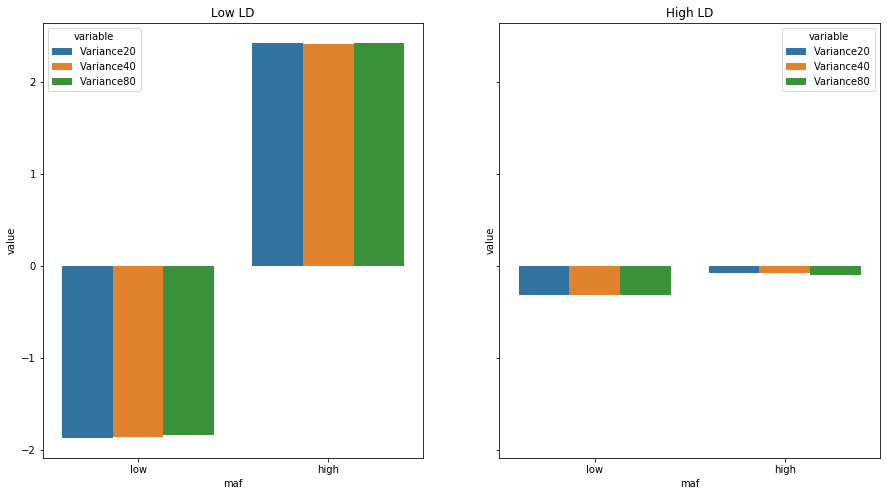

In [104]:
low = hsq_var_melt[hsq_var_melt.ld=='low']
high = hsq_var_melt[hsq_var_melt.ld=='high']

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
fig.set_figheight(8)
fig.set_figwidth(15)
sns.barplot(low.maf, low.value, hue=low.variable, ax=ax1)
ax1.title.set_text("Low LD")

sns.barplot(high.maf, high.value, hue=high.variable, ax=ax2)
ax2.title.set_text("High LD")